use pre-trained models as often as possible (or the backbones) - abstractions - person segmentation, optical flow .... 

temporal consistency (with hierarchy) - person keypoint detection 

combined with optical flow 



In [1]:
import torch
import torchvision
from torchvision.datasets.utils import download_url

# Download the sample video
# download_url(
#     "https://github.com/pytorch/vision/blob/main/test/assets/videos/WUzgd7C1pWA.mp4?raw=true",
#     ".",
#     "WUzgd7C1pWA.mp4"
# )
video_path = "./mission_impossible_w_subtitle.mp4"

In [5]:
# import ffmpeg

# in_file = ffmpeg.input('./WUzgd7C1pWA.mp4')
# overlay_file = ffmpeg.input('overlay.png')
# (
#     ffmpeg
#     .concat(
#         in_file.trim(start_frame=10, end_frame=20),
#         in_file.trim(start_frame=30, end_frame=40),
#     )
#     .overlay(overlay_file.hflip())
#     .drawbox(50, 50, 120, 120, color='red', thickness=5)
#     .output('out.mp4')
#     .run()
# )

In [10]:
stream = "video"
video = torchvision.io.VideoReader(video_path, stream)
video.get_metadata()

{'video': {'duration': [310.71], 'fps': [29.97002997002997]},
 'audio': {'duration': [310.79909299999997], 'framerate': [44100.0]},
 'subtitles': {'duration': []},
 'cc': {'duration': []}}

can we embed and use a subtitle in the video ?


https://colab.research.google.com/github/spmallick/learnopencv/blob/master/PyTorch-Segmentation-torchvision/intro-seg.ipynb


segmentation 


In [11]:
metadata = video.get_metadata()
video.set_current_stream("audio")

frames = []  # we are going to save the frames here.
ptss = []  # pts is a presentation timestamp in seconds (float) of each frame
for frame in video:
    frames.append(frame['data'])
    ptss.append(frame['pts'])

print("PTS for first five frames ", ptss[:5])
print("Total number of frames: ", len(frames))
approx_nf = metadata['audio']['duration'][0] * metadata['audio']['framerate'][0]
print("Approx total number of datapoints we can expect: ", approx_nf)
print("Read data size: ", frames[0].size(0) * len(frames))

PTS for first five frames  [0.0, 0.023219999999999998, 0.046439999999999995, 0.06966, 0.09287999999999999]
Total number of frames:  13385
Approx total number of datapoints we can expect:  13706240.001299998
Read data size:  13706240


In [12]:
import itertools
video.set_current_stream("video")

frames = []  # we are going to save the frames here.

# We seek into a second second of the video and use islice to get 10 frames since
for frame, pts in itertools.islice(video.seek(2), 10):
    frames.append(frame)

print("Total number of frames: ", len(frames))


Total number of frames:  10


In [13]:
video.set_current_stream("video")
frames = []  # we are going to save the frames here.
video = video.seek(2)

for frame in itertools.takewhile(lambda x: x['pts'] <= 5, video):
    frames.append(frame['data'])

print("Total number of frames: ", len(frames))
approx_nf = (5 - 2) * video.get_metadata()['video']['fps'][0]
print("We can expect approx: ", approx_nf)
print("Tensor size: ", frames[0].size())

Total number of frames:  90
We can expect approx:  89.91008991008991
Tensor size:  torch.Size([3, 360, 640])


In [4]:
from torchvision import models
import torchvision.transforms as T
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

/home/michael/anaconda3/envs/machine-learning/lib/python3.7/site-packages/torchvision-0.13.0a0+3fa2414-py3.7-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated, please use '{weights_param}' instead."
/home/michael/anaconda3/envs/machine-learning/lib/python3.7/site-packages/torchvision-0.13.0a0+3fa2414-py3.7-linux-x86_64.egg/torchvision/models/_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

In [6]:
import numpy as np
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [28]:
def segment(net, img, show_orig=True, dev='cuda'):
  # img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(240), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0) # .to(dev)
  out = net(inp)['out'] # net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

In [9]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

/home/michael/anaconda3/envs/machine-learning/lib/python3.7/site-packages/torchvision-0.13.0a0+3fa2414-py3.7-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated, please use '{weights_param}' instead."
/home/michael/anaconda3/envs/machine-learning/lib/python3.7/site-packages/torchvision-0.13.0a0+3fa2414-py3.7-linux-x86_64.egg/torchvision/models/_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


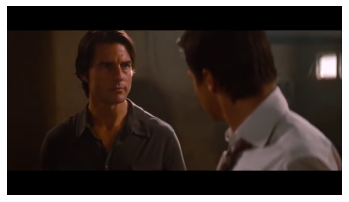

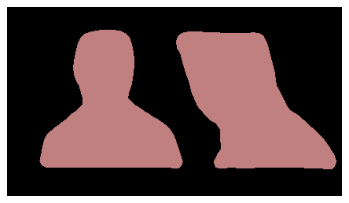

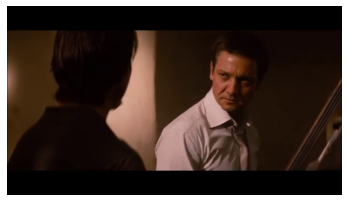

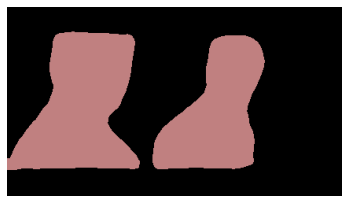

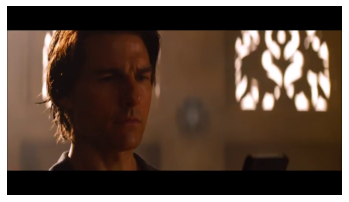

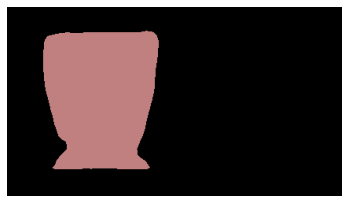

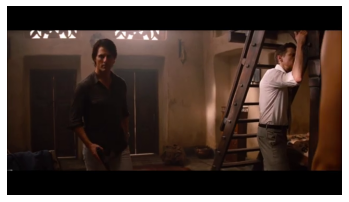

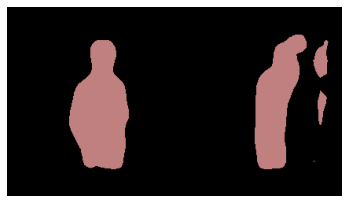

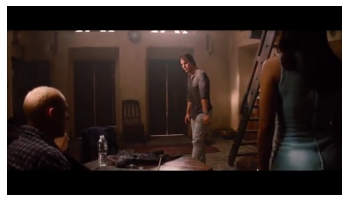

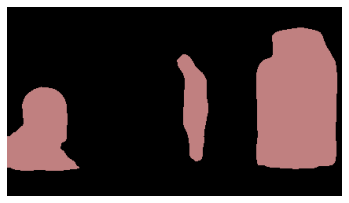

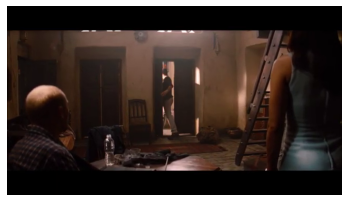

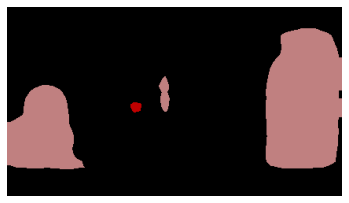

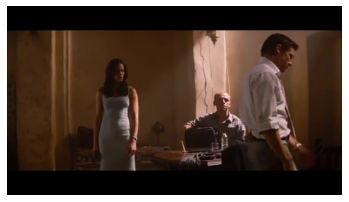

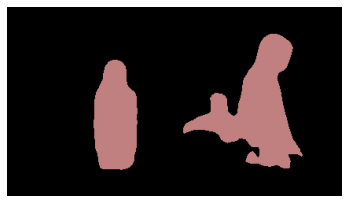

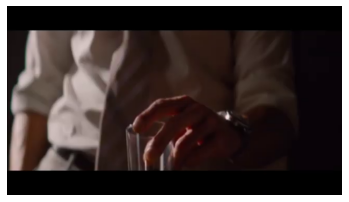

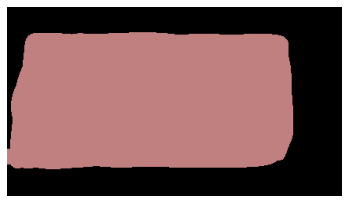

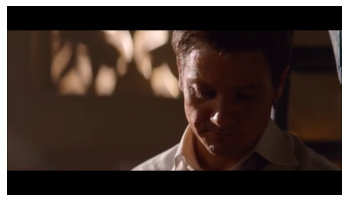

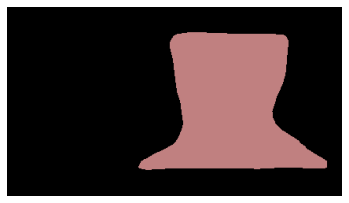

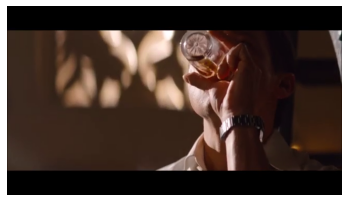

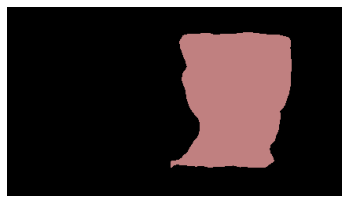

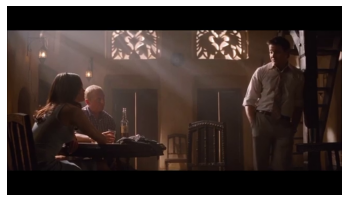

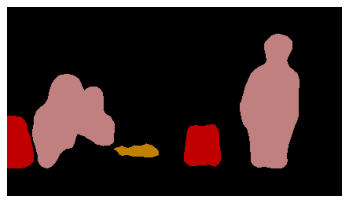

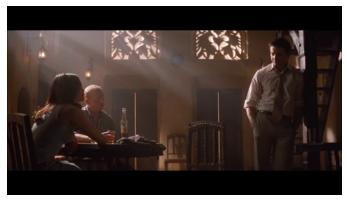

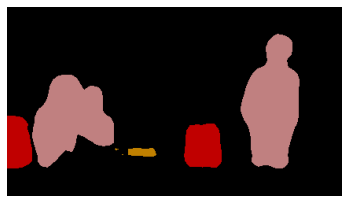

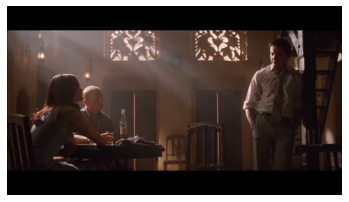

KeyboardInterrupt: 

In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

transform = T.ToPILImage()

for i, frame in enumerate(video):

    if i % 200 == 0:
        img = frame['data']# .permute(1,2,0)

        #plt.imshow(img)
        #plt.show()
        segment(fcn, transform(img))
        # segment(fcn, img.cpu().detach().numpy())


        #inp = trf(img).unsqueeze(0)
        #out = fcn(inp)['out']
        #om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
        #rgb = decode_segmap(om)
        #plt.imshow(rgb); plt.show()


        #print (out.shape)

    

In [ ]:
# optical flow between two images 